## Dashboard Static Map 

The OSM code is from a blog post on the urbanist: https://www.theurbanist.com.au/2021/03/plotting-openstreetmap-images-with-cartopy/

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe  
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.' 

In [75]:
def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(10,10)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    # ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    print(extent)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(16)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='o', ms=17, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='#e28743', marker='o', ms=12, mew=2, transform=data_crs)

    gl = ax.gridlines(draw_labels=False, crs=data_crs,
                        color='k',lw=0)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1]+.0, top_left[1]+.0] # Can add add to the extent to make the map a bit bigger

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

[-120.90128429029843, -120.816551977662, 35.33609134408036, 35.405493603111665]


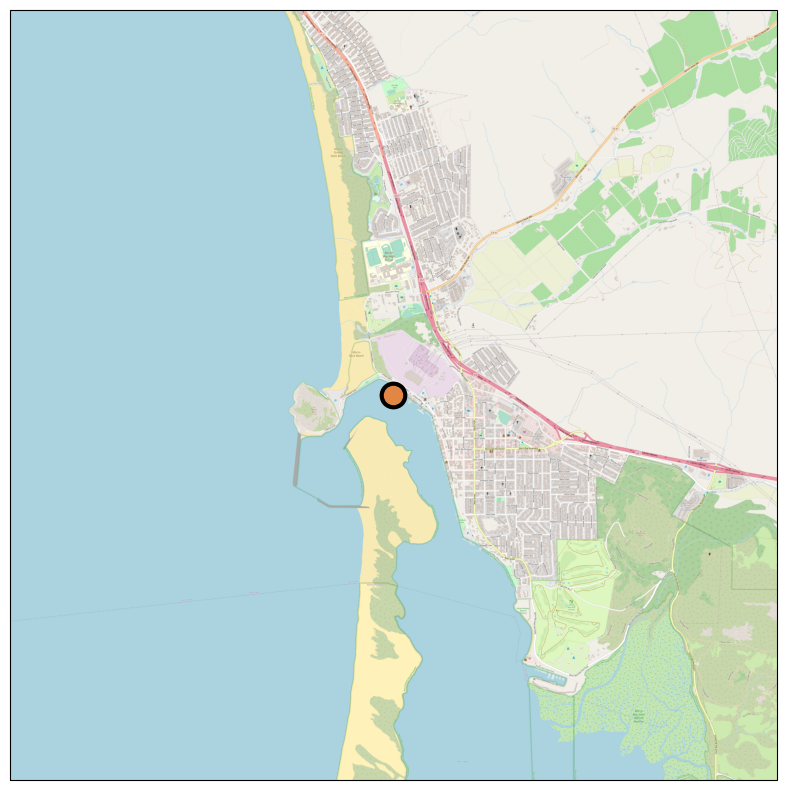

In [76]:
sitename = 'Morro-BM'
lat = 35.3708
lon = -120.8589
osm_image(lon, lat, sitename=sitename,style='map', npoints=0, radius=3500)

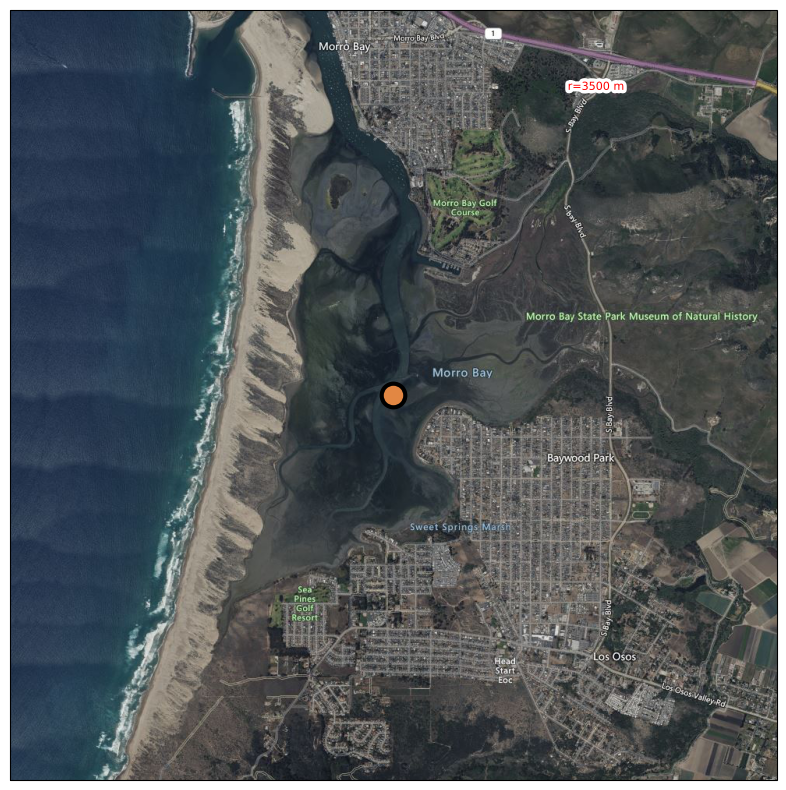

In [53]:
sitename = 'Morro'
lat = 35.3338
lon = -120.8473
osm_image(lon, lat, sitename=sitename,style='satellite', npoints=0, radius=3500)